<a href="https://colab.research.google.com/github/sivask01/CMPE-255-01/blob/main/face_mask_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
# from PIL import Image
# import xml.etree.ElementTree as ET

In [ ]:
#For model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#For shwing images and graphs
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
extracted_folder_path = '/content/drive/MyDrive/Colab Notebooks/255_Project/'
extracted_folder_path

'/content/drive/MyDrive/Colab Notebooks/255_Project/'

#**Parellel Processing**

In [24]:
# # Example of using MirroredStrategy for multi-GPU training
# import tensorflow as tf

# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     # Reinitialize and compile your model here


#**DATA LOADING**

Images from CMFD (Correctly Masked Face Dataset):


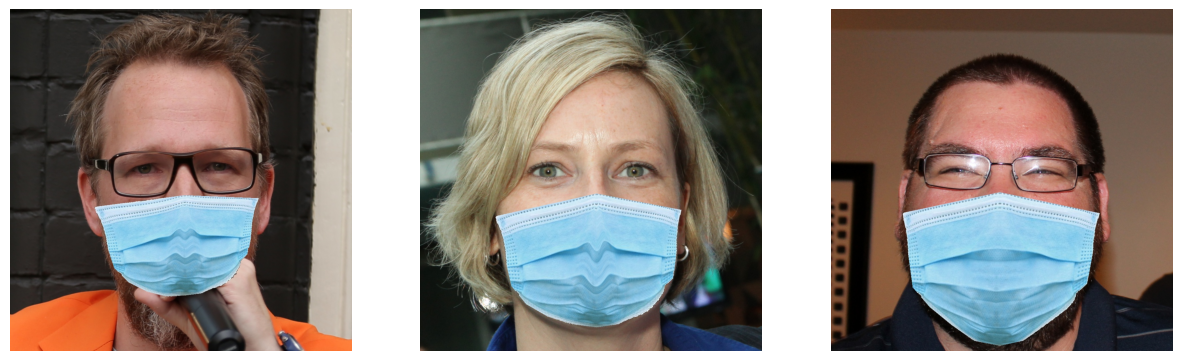

Images from IMFD (Incorrectly Masked Face Dataset):


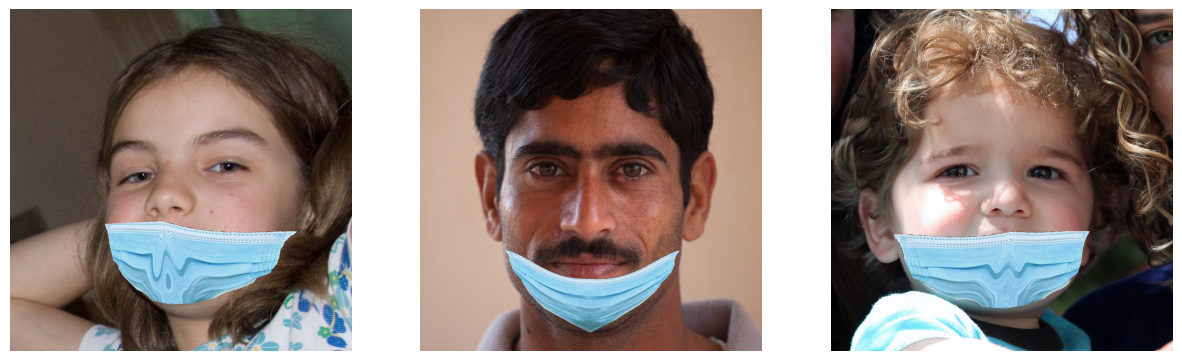

Images from No Mask:


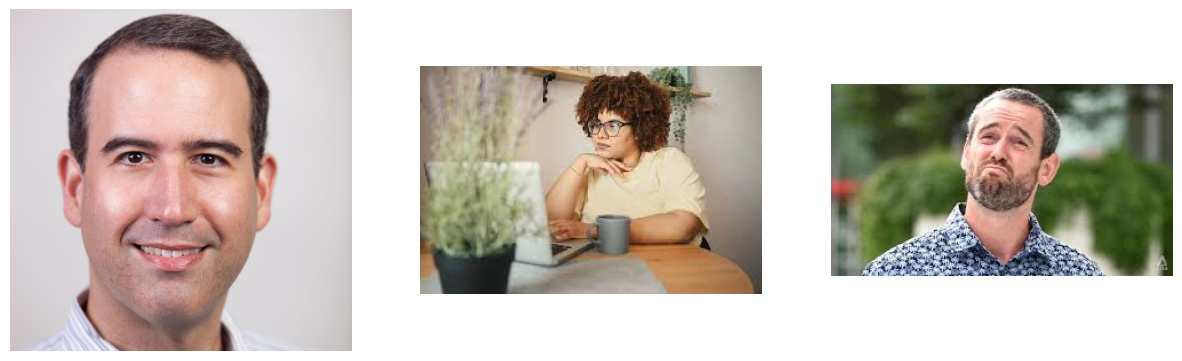

In [29]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to display images
def display_images(folder_path, num_images=3):
    image_files = os.listdir(folder_path)[:num_images]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for ax, image_file in zip(axes, image_files):
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Displaying images from each category
print("Images from CMFD (Correctly Masked Face Dataset):")
display_images(f"{extracted_folder_path}/Classes/CMFD")

print("Images from IMFD (Incorrectly Masked Face Dataset):")
display_images(f"{extracted_folder_path}/Classes/IMFD")

print("Images from No Mask:")
display_images(f"{extracted_folder_path}/Classes/NO_MASK")

#**DATA PRE PROCESSING**

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

# Parameters for preprocessing
image_size = (64, 64)  # Standard size for the images
batch_size = 16        # Batch size for processing

# Setting up the ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,       # Normalizing the pixel values
    validation_split=0.2  # Splitting 20% data for validation
)

# Preparing the training and validation generators
train_generator = datagen.flow_from_directory(
    directory=f"{extracted_folder_path}/Classes",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',   # Since we have two classes
    subset='training'      # Training data
)

validation_generator = datagen.flow_from_directory(
    directory=f"{extracted_folder_path}/Classes",
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',   # Since we have two classes
    subset='validation'    # Validation data
)

# Checking the class indices
class_indices = train_generator.class_indices
class_indices


Found 1506 images belonging to 3 classes.
Found 375 images belonging to 3 classes.


{'CMFD': 0, 'IMFD': 1, 'NO_MASK': 2}

#**MODEL ARCHITECTURE**

##**Creating a Model(CNN)**

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    # Dense(1, activation='sigmoid')  # Binary classification
    Dense(3, activation='softmax')  # For three classes
])


##**Compile & Train the Model**

In [33]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=2 # Adjust as necessary
)

Epoch 1/2
94/94 [==============================] - 41s 414ms/step - loss: 0.3909 - accuracy: 0.8342 - val_loss: 0.0931 - val_accuracy: 0.9674
Epoch 2/2
94/94 [==============================] - 37s 392ms/step - loss: 0.1421 - accuracy: 0.9631 - val_loss: 0.0483 - val_accuracy: 0.9810


#**Model Testing**

In [36]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Path to your test folder
test_folder_path = f"{extracted_folder_path}/Test_Classes"

# Get all image paths from the test folder
test_images = [os.path.join(test_folder_path, file) for file in os.listdir(test_folder_path) if file.endswith('.jpg')]

# Adjusted prediction function
def predict_image(image_path, model):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)
    # print("index of highest", np.argmax(prediction, axis=1))
    return np.argmax(prediction, axis=1)  # Returns the index of the highest probability

# Class labels
class_labels = ['CMFD', 'IMFD', 'No Mask']

# Predict each test image
for image_path in test_images:
    predicted_index = predict_image(image_path, model)[0]
    class_prediction = class_labels[predicted_index]
    print(f"Image: {os.path.basename(image_path)}, Prediction: {class_prediction}")


1/1 [==============================] - 0s 44ms/step
index of highest [0]
Image: 37002_Mask.jpg, Prediction: CMFD
1/1 [==============================] - 0s 42ms/step
index of highest [0]
Image: 37003_Mask.jpg, Prediction: CMFD
1/1 [==============================] - 0s 42ms/step
index of highest [0]
Image: 37001_Mask.jpg, Prediction: CMFD
1/1 [==============================] - 0s 39ms/step
index of highest [1]
Image: mixed.jpg, Prediction: IMFD
1/1 [==============================] - 0s 40ms/step
index of highest [1]
Image: no_mask.jpg, Prediction: IMFD
1/1 [==============================] - 0s 38ms/step
index of highest [1]
Image: InCorrectMask.jpg, Prediction: IMFD
1/1 [==============================] - 0s 36ms/step
index of highest [1]
Image: InCorrectMask2.jpg, Prediction: IMFD
1/1 [==============================] - 0s 40ms/step
index of highest [1]
Image: no_mask2.jpg, Prediction: IMFD
